In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/DeepGap')

In [3]:
# Imports
import os
import glob
import warnings
from pathlib import Path
from typing import List, Tuple, Optional
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.0+cu126
CUDA available: True
CUDA device: Tesla T4


In [4]:
# Configuration
class Config:
    # Data paths
    DATA_DIR = "data/tqbr"

    # Model hyperparameters
    SEQUENCE_LENGTH = 60  # Number of days to look back
    HIDDEN_SIZE = 128
    NUM_LAYERS = 2
    DROPOUT = 0.2
    BIDIRECTIONAL = False
    NUM_BASE_STOCKS = 10  # Number of base stocks to use

    # Training hyperparameters
    BATCH_SIZE = 64
    LEARNING_RATE = 0.001
    NUM_EPOCHS = 50
    EARLY_STOPPING_PATIENCE = 10
    VALIDATION_SPLIT = 0.2

    # Device
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model save path
    MODEL_SAVE_DIR = "models"
    MODEL_NAME = "lstm_multi_stock_model.pth"

config = Config()
print(f"Using device: {config.DEVICE}")

# Hardcoded 10 prominent stocks from different sectors on MOEX
# These stocks represent diverse sectors to ensure low correlation
base_stocks = [
    'SBER',  # Sberbank - Banking
    'VTBR',  # VTB Bank - Banking
    'GAZP',  # Gazprom - Energy/Oil & Gas
    'LKOH',  # Lukoil - Energy/Oil & Gas
    'MGNT',  # Magnit - Retail
    'X5',    # X5 Group - Retail
    'YNDX',  # Yandex - Technology/Internet
    'MTSS',  # MTS - Telecommunications
    'NLMK',  # NLMK - Steel/Metals
    'PLZL'   # Polymetal - Gold/Mining
]

print(f"Using {len(base_stocks)} base stocks from diverse sectors:")
for i, stock in enumerate(base_stocks, 1):
    sector = [
        "Banking", "Banking", "Energy/Oil & Gas", "Energy/Oil & Gas",
        "Retail", "Retail", "Technology/Internet", "Telecommunications",
        "Steel/Metals", "Gold/Mining"
    ][i-1]
    print(f"{i}. {stock} - {sector}")

Using device: cuda
Using 10 base stocks from diverse sectors:
1. SBER - Banking
2. VTBR - Banking
3. GAZP - Energy/Oil & Gas
4. LKOH - Energy/Oil & Gas
5. MGNT - Retail
6. X5 - Retail
7. YNDX - Technology/Internet
8. MTSS - Telecommunications
9. NLMK - Steel/Metals
10. PLZL - Gold/Mining


In [5]:
def load_all_stock_data(data_dir: str) -> pd.DataFrame:
    """
    Load all CSV files from the data directory and combine them.
    Returns a DataFrame with columns: ticker, Date, Close, Close_Return
    """
    all_data = []
    csv_files = glob.glob(os.path.join(data_dir, "*.csv"))

    print(f"Found {len(csv_files)} CSV files")

    for file_path in csv_files:
        ticker = Path(file_path).stem
        try:
            df = pd.read_csv(file_path)
            if 'Date' in df.columns and 'Close' in df.columns:
                df['Date'] = pd.to_datetime(df['Date'])
                df = df.sort_values('Date')

                # Calculate Close Return (percentage change * 100)
                df['Close_Return'] = df['Close'].pct_change() * 100

                # Add ticker column
                df['Ticker'] = ticker

                # Keep only necessary columns
                df = df[['Ticker', 'Date', 'Close', 'Close_Return']].copy()

                # Drop first row (NaN from pct_change)
                df = df.dropna().reset_index(drop=True)

                if len(df) > config.SEQUENCE_LENGTH:  # Only keep stocks with enough data
                    all_data.append(df)
        except Exception as e:
            print(f"Error loading {ticker}: {e}")
            continue

    if not all_data:
        raise ValueError("No data loaded!")

    combined_df = pd.concat(all_data, ignore_index=True)
    print(f"Total records: {len(combined_df)}")
    print(f"Unique tickers: {combined_df['Ticker'].nunique()}")
    print(f"Date range: {combined_df['Date'].min()} to {combined_df['Date'].max()}")

    return combined_df

In [6]:
# Load data
df_all = load_all_stock_data(config.DATA_DIR)
df_all.head()

# clip garbage
df_all['Close_Return'] = np.clip(df_all.Close_Return.to_numpy(), -20.0, 20.0)

Found 258 CSV files
Total records: 554141
Unique tickers: 254
Date range: 2013-03-26 00:00:00 to 2025-10-10 00:00:00


In [7]:
def prepare_multi_stock_sequences(df: pd.DataFrame, base_stocks: List[str], sequence_length: int) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    """
    Create sequences for LSTM training using returns from base stocks and the stock of interest.

    Args:
        df: DataFrame with Date, Ticker, and Close_Return columns
        base_stocks: List of ticker symbols for the base stocks
        sequence_length: Number of time steps to use as input

    Returns:
        X: Array of shape (n_sequences, sequence_length, n_features)
        y: Array of shape (n_sequences,) - next day's Close_Return for stock of interest
        feature_names: List of feature names (base stocks + stock of interest)
    """
    # Get all unique tickers
    all_stocks = df['Ticker'].unique().tolist()

    # Create a pivot table with dates as index, tickers as columns, and returns as values
    pivot_df = df.pivot_table(index='Date', columns='Ticker', values='Close_Return')

    # Forward fill missing values (assuming no trading days have missing data)
    pivot_df = pivot_df.fillna(method='ffill').dropna()

    # Get the list of all dates
    dates = pivot_df.index.tolist()

    sequences_X = []
    sequences_y = []
    feature_names = base_stocks.copy()  # Start with base stocks

    # For each stock, create sequences
    for target_stock in all_stocks:
        # Skip if target stock doesn't have enough data
        if target_stock not in pivot_df.columns:
            continue

        # Get the returns for the target stock
        target_returns = pivot_df[target_stock].values

        # Add target stock to feature names if not already there
        if target_stock not in feature_names:
            feature_names.append(target_stock)

        # For each date, create a feature vector with returns from base stocks and target stock
        for i in range(sequence_length, len(dates) - 1):  # -1 because we need next day's return as target
            # Get the sequence of returns for base stocks
            base_stock_returns = []
            for base_stock in base_stocks:
                if base_stock in pivot_df.columns:
                    base_stock_returns.append(pivot_df[base_stock].iloc[i-sequence_length:i].values)
                else:
                    # If base stock data is missing, use zeros
                    base_stock_returns.append(np.zeros(sequence_length))

            # Get the sequence of returns for the target stock
            target_stock_returns = pivot_df[target_stock].iloc[i-sequence_length:i].values

            # Combine all returns into a feature matrix
            # Shape: (sequence_length, num_base_stocks + 1)
            feature_matrix = np.column_stack(base_stock_returns + [target_stock_returns])

            # Get the next day's return for the target stock
            next_day_return = pivot_df[target_stock].iloc[i+1]

            sequences_X.append(feature_matrix)
            sequences_y.append(next_day_return)

    X = np.array(sequences_X, dtype=np.float32)
    y = np.array(sequences_y, dtype=np.float32)

    print(f"Created {len(sequences_X)} sequences")
    print(f"X shape: {X.shape}, y shape: {y.shape}")

    return X, y, feature_names

In [8]:
# Prepare sequences
X, y, feature_names = prepare_multi_stock_sequences(df_all, base_stocks, config.SEQUENCE_LENGTH)
print(f"\nFeature names: {feature_names}")
print(f"\nClose Return statistics:")
print(f"Mean: {y.mean():.4f}, Std: {y.std():.4f}")
print(f"Min: {y.min():.4f}, Max: {y.max():.4f}")

Created 5080 sequences
X shape: (5080, 60, 11), y shape: (5080,)

Feature names: ['SBER', 'VTBR', 'GAZP', 'LKOH', 'MGNT', 'X5', 'YNDX', 'MTSS', 'NLMK', 'PLZL', 'ALRS', 'ABIO', 'ABRD', 'AFLT', 'AFKS', 'AKRN', 'APRI', 'AQUA', 'AVAN', 'APTK', 'ASTR', 'ARSA', 'AMEZ', 'ASSB', 'BANE', 'BANEP', 'BELU', 'BISVP', 'BLNG', 'BRZL', 'BSPB', 'BSPBP', 'CARM', 'CBOM', 'CHGZ', 'CHKZ', 'CHMF', 'CHMK', 'CNRU', 'CNTL', 'CNTLP', 'DATA', 'DELI', 'DIAS', 'DIOD', 'DVEC', 'DZRD', 'DZRDP', 'EELT', 'ELFV', 'ELMT', 'ENPG', 'ETLN', 'EUTR', 'FEES', 'FESH', 'FLOT', 'GAZA', 'GAZAP', 'GCHE', 'GECO', 'GEMA', 'GEMC', 'GMKN', 'GTRK', 'HEAD', 'HIMCP', 'HNFG', 'HYDR', 'IGST', 'IGSTP', 'IRAO', 'IRKT', 'IVAT', 'JNOS', 'JNOSP', 'KAZT', 'KAZTP', 'KBSB', 'KCHE', 'KCHEP', 'KFBA', 'KGKC', 'KGKCP', 'KLSB', 'KLVZ', 'KMAZ', 'KMEZ', 'KOGK', 'KRKN', 'KRKNP', 'KRKOP', 'KROT', 'KROTP', 'KRSB', 'KRSBP', 'KUZB', 'KZOS', 'KZOSP', 'LEAS', 'LENT', 'LIFE', 'LMBZ', 'LNZL', 'LNZLP', 'LPSB', 'LSNG', 'LSNGP', 'LSRG', 'LVHK', 'MAGE', 'MAGEP', 'MAG

In [9]:
print(X.shape)
print(y.shape)

(5080, 60, 11)
(5080,)


(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   1.,   1.,   0.,   1.,   1.,   1.,
          0.,   0.,   0.,   2.,   4.,   1.,   5.,   2.,   5.,   6.,   2.,
          4.,   7.,  13.,  22.,  20.,  40.,  83.,  75., 115., 155., 212.,
        233., 322., 421., 491., 498., 408., 525., 355., 240., 200., 143.,
        106., 112.,  49.,  41.,  31.,  25.,  18.,  13.,  15.,  10.,   5.,
          4.,   4.,   2.,   3.,   6.,   1.,   3.,   2.,   5.,   0.,   0.,
          2.,   0.,   1.,   0.,   1.,   1.,   0.,   1.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-20.        , -19.60000038, -19.20000076, -18.79999924,
        -18.39999962, -18.        , -17.60000038, -17.20000076,
        -16.79999924, -16.39999962, -16.        , -15.60000038,
        -15.19999981, -14.79999924, -14.39999962, -14.        ,
        -13.60000038, -13.19999981, -12.79999924, -12.39999962

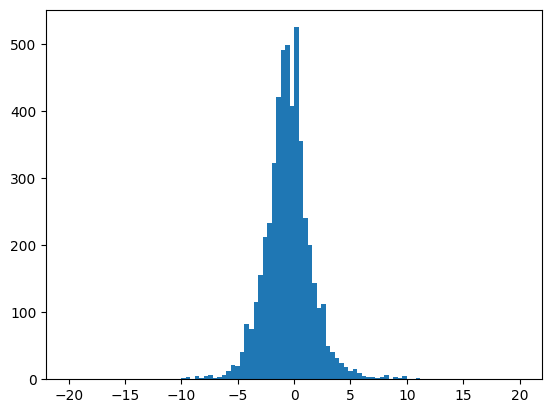

In [10]:
plt.hist(y[(-100.0 < y) & (y < 100.0)], bins=100)

In [11]:
for q in (1.0, 0.999, 0.99, 0.98, 0.95, 0.001, 0.0):
  print(np.quantile(y, q))

20.0
12.664572
5.737077
4.3847303
2.7692013
-11.60347
-20.0


In [12]:
# Train/Validation split
def train_val_split(X: np.ndarray, y: np.ndarray, val_split: float = 0.2, shuffle: bool = True) -> Tuple:
    """Split data into train and validation sets."""
    n_samples = len(X)
    n_val = int(n_samples * val_split)

    if shuffle:
        indices = np.random.permutation(n_samples)
        X = X[indices]
        y = y[indices]

    X_train, X_val = X[:-n_val], X[-n_val:]
    y_train, y_val = y[:-n_val], y[-n_val:]

    print(f"Train: {len(X_train)} samples, Val: {len(X_val)} samples")
    return X_train, X_val, y_train, y_val

X_train, X_val, y_train, y_val = train_val_split(X, y, config.VALIDATION_SPLIT, shuffle=True)

# # Normalize features (fit on training data only)
# scaler_X = StandardScaler()
# # Reshape for scaler: (n_samples * seq_length, n_features)
# n_train, seq_len, n_features = X_train.shape
# X_train_reshaped = X_train.reshape(-1, n_features)
# X_train_scaled = scaler_X.fit_transform(X_train_reshaped)
# X_train = X_train_scaled.reshape(n_train, seq_len, n_features)

# # Transform validation data
# n_val, _, _ = X_val.shape
# X_val_reshaped = X_val.reshape(-1, n_features)
# X_val_scaled = scaler_X.transform(X_val_reshaped)
# X_val = X_val_scaled.reshape(n_val, seq_len, n_features)

print(f"\nAfter normalization:")
print(f"Train X - Mean: {X_train.mean():.4f}, Std: {X_train.std():.4f}")
print(f"Val X - Mean: {X_val.mean():.4f}, Std: {X_val.std():.4f}")

Train: 4064 samples, Val: 1016 samples

After normalization:
Train X - Mean: -0.0462, Std: 1.8624
Val X - Mean: -0.0453, Std: 1.8490


In [13]:
class StockSequenceDataset(Dataset):
    """
    PyTorch Dataset for stock sequences.
    Modular design allows easy extension for additional features.
    """
    def __init__(self, X: np.ndarray, y: np.ndarray):
        """
        Args:
            X: Input sequences of shape (n_samples, sequence_length, n_features)
            y: Target values of shape (n_samples,)
        """
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = StockSequenceDataset(X_train, y_train)
val_dataset = StockSequenceDataset(X_val, y_val)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

Train batches: 64, Val batches: 16


In [14]:
class LSTMModel(nn.Module):
    """
    LSTM model for time series forecasting.
    Modular architecture allows easy extension (e.g., attention, multiple outputs).
    """
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers: int,
        dropout: float = 0.2,
        bidirectional: bool = False
    ):
        super(LSTMModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional,
            batch_first=True
        )

        # Calculate LSTM output size
        lstm_output_size = hidden_size * 2 if bidirectional else hidden_size

        # Fully connected layers
        self.fc1 = nn.Linear(lstm_output_size, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, 1)  # Single output for regression

        self.relu = nn.ReLU()

    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (batch_size, sequence_length, input_size)

        Returns:
            output: Tensor of shape (batch_size, 1)
        """
        # LSTM forward pass
        lstm_out, (h_n, c_n) = self.lstm(x)

        # Use the last output (many-to-one architecture)
        # lstm_out shape: (batch_size, sequence_length, hidden_size)
        last_output = lstm_out[:, -1, :]  # (batch_size, hidden_size)

        # Fully connected layers
        out = self.fc1(last_output)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)

        return out.squeeze(-1)  # (batch_size,)

# Initialize model
n_features = X_train.shape[2]
model = LSTMModel(
    input_size=n_features,
    hidden_size=config.HIDDEN_SIZE,
    num_layers=config.NUM_LAYERS,
    dropout=config.DROPOUT,
    bidirectional=config.BIDIRECTIONAL
).to(config.DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model initialized on {config.DEVICE}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Model architecture summary
print("\nModel architecture:")
print(model)

Model initialized on cuda
Total parameters: 220,929
Trainable parameters: 220,929

Model architecture:
LSTMModel(
  (lstm): LSTM(11, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)


In [15]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

class Trainer:
    """
    Modular trainer class for LSTM model.
    Handles training loop, validation, early stopping, and metrics tracking.
    Now includes checkpointing functionality.
    """
    def __init__(
        self,
        model: nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        optimizer: optim.Optimizer,
        criterion: nn.Module,
        device: torch.device,
        model_name: str = "lstm_model",
        early_stopping_patience: int = 10
    ):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.model_name = model_name
        self.early_stopping_patience = early_stopping_patience

        # Training history
        self.train_losses = []
        self.val_losses = []
        self.best_val_loss = float('inf')
        self.patience_counter = 0
        self.best_model_state = None

        # Create checkpoint directory if it doesn't exist
        self.checkpoint_dir = "checkpoints"
        os.makedirs(self.checkpoint_dir, exist_ok=True)

        # Path to the model checkpoint
        self.checkpoint_path = os.path.join(self.checkpoint_dir, f"{self.model_name}_best.pt")

    def train_epoch(self) -> float:
        """Train for one epoch and return average loss."""
        self.model.train()
        total_loss = 0.0
        n_batches = 0

        for batch_X, batch_y in self.train_loader:
            batch_X = batch_X.to(self.device)
            batch_y = batch_y.to(self.device)

            # Forward pass
            self.optimizer.zero_grad()
            predictions = self.model(batch_X)
            loss = self.criterion(predictions, batch_y)

            # Backward pass
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            n_batches += 1

        return total_loss / n_batches

    def validate(self) -> float:
        """Validate and return average loss."""
        self.model.eval()
        total_loss = 0.0
        n_batches = 0

        with torch.no_grad():
            for batch_X, batch_y in self.val_loader:
                batch_X = batch_X.to(self.device)
                batch_y = batch_y.to(self.device)

                predictions = self.model(batch_X)
                loss = self.criterion(predictions, batch_y)

                total_loss += loss.item()
                n_batches += 1

        return total_loss / n_batches

    def save_checkpoint(self, is_best: bool, epoch: int, val_loss: float):
        """Save model checkpoint."""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'val_loss': val_loss,
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'best_val_loss': self.best_val_loss
        }

        # Save the latest checkpoint
        torch.save(checkpoint, os.path.join(self.checkpoint_dir, f"{self.model_name}_latest.pt"))

        # Save the best checkpoint if this is the best model
        if is_best:
            torch.save(checkpoint, self.checkpoint_path)
            print(f"New best model saved with validation loss: {val_loss:.6f}")

    def load_checkpoint(self):
        """Load model checkpoint if it exists."""
        if os.path.exists(self.checkpoint_path):
            print(f"Loading checkpoint from {self.checkpoint_path}")
            checkpoint = torch.load(self.checkpoint_path, map_location=self.device)

            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.train_losses = checkpoint.get('train_losses', [])
            self.val_losses = checkpoint.get('val_losses', [])
            self.best_val_loss = checkpoint.get('best_val_loss', float('inf'))

            start_epoch = checkpoint['epoch'] + 1
            print(f"Resuming training from epoch {start_epoch}")
            print(f"Best validation loss so far: {self.best_val_loss:.6f}")
            return start_epoch
        else:
            print("No checkpoint found. Starting training from scratch.")
            return 0

    def train(self, num_epochs: int) -> dict:
        """Main training loop with early stopping and checkpointing."""
        # Try to load a checkpoint if it exists
        start_epoch = self.load_checkpoint()

        print("Starting training...")
        print(f"{'Epoch':<8} {'Train Loss':<15} {'Val Loss':<15} {'Status':<10}")
        print("-" * 50)

        for epoch in range(start_epoch, num_epochs):
            train_loss = self.train_epoch()
            val_loss = self.validate()

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)

            # Early stopping check
            is_best = False
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.patience_counter = 0
                self.best_model_state = self.model.state_dict().copy()
                is_best = True
                status = "Improved"
            else:
                self.patience_counter += 1
                status = f"Patience {self.patience_counter}/{self.early_stopping_patience}"

            # Save checkpoint if this is the best model
            if is_best:
                self.save_checkpoint(is_best, epoch, val_loss)

            if (epoch + 1) % 5 == 0 or epoch == 0:
                print(f"{epoch+1:<8} {train_loss:<15.6f} {val_loss:<15.6f} {status:<10}")

            if self.patience_counter >= self.early_stopping_patience:
                print(f"\nEarly stopping triggered at epoch {epoch+1}")
                break

        # Load best model
        if self.best_model_state is not None:
            self.model.load_state_dict(self.best_model_state)

        print(f"\nTraining completed. Best validation loss: {self.best_val_loss:.6f}")

        return {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'best_val_loss': self.best_val_loss
        }

In [16]:
# Initialize optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
criterion = nn.MSELoss()

# Create trainer with model name
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=config.DEVICE,
    model_name="lstm_multi_stock_predictor",  # Specify your model name here
    early_stopping_patience=config.EARLY_STOPPING_PATIENCE
)

# Train model
history = trainer.train(config.NUM_EPOCHS)

No checkpoint found. Starting training from scratch.
Starting training...
Epoch    Train Loss      Val Loss        Status    
--------------------------------------------------
New best model saved with validation loss: 4.607110
1        4.903244        4.607110        Improved  
New best model saved with validation loss: 3.926821
New best model saved with validation loss: 3.692243
New best model saved with validation loss: 3.621336
5        3.887071        3.647983        Patience 1/10
New best model saved with validation loss: 3.606539
New best model saved with validation loss: 3.552115
10       3.624621        3.565033        Patience 3/10
New best model saved with validation loss: 3.537513
New best model saved with validation loss: 3.505087
15       3.361740        3.588619        Patience 2/10
20       2.990092        3.583140        Patience 7/10

Early stopping triggered at epoch 23

Training completed. Best validation loss: 3.505087


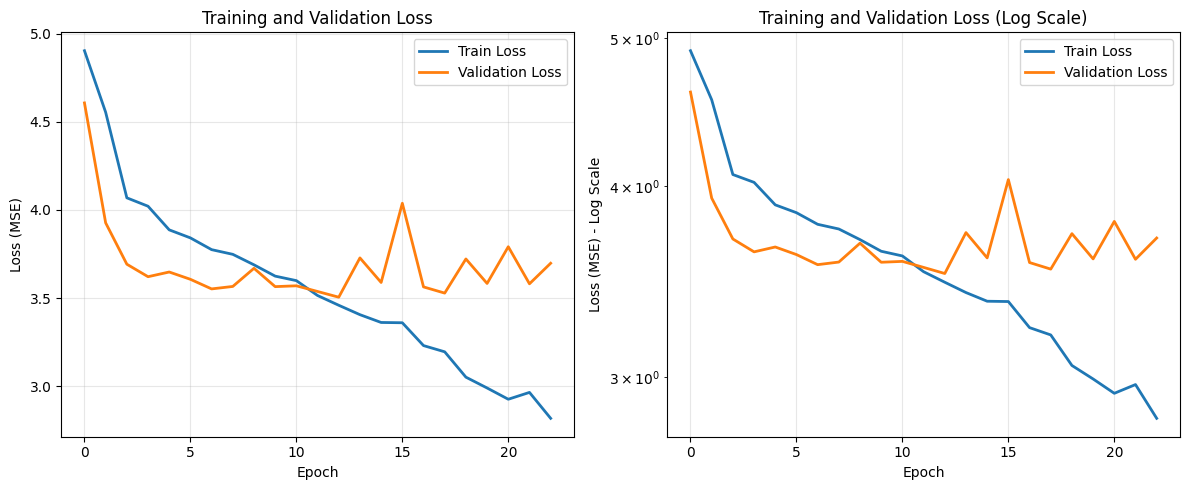

In [17]:
# Plot training curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_losses'], label='Train Loss', linewidth=2)
plt.plot(history['val_losses'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history['train_losses'], label='Train Loss', linewidth=2)
plt.plot(history['val_losses'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE) - Log Scale')
plt.title('Training and Validation Loss (Log Scale)')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculate MAPE (Mean Absolute Percentage Error)."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero by filtering out zero values in y_true
    mask = y_true != 0
    if np.sum(mask) == 0:
        # If all values are zero, return 0 to avoid division by zero
        return 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def evaluate_model(model: nn.Module, data_loader: DataLoader, device: torch.device) -> dict:
    """Evaluate model and return metrics."""
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            batch_X = batch_X.to(device)
            predictions = model(batch_X)

            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(batch_y.numpy())

    predictions = np.array(all_predictions)
    targets = np.array(all_targets)

    # Calculate metrics
    mse = mean_squared_error(targets, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(targets, predictions)
    mape = mean_absolute_percentage_error(targets, predictions)

    # Calculate directional accuracy (sign prediction)
    pred_sign = np.sign(predictions)
    target_sign = np.sign(targets)
    directional_accuracy = (pred_sign == target_sign).mean() * 100

    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'directional_accuracy': directional_accuracy,
        'predictions': predictions,
        'targets': targets
    }

In [19]:
# Evaluate on train and validation sets
print("Evaluating model...")
train_metrics = evaluate_model(model, train_loader, config.DEVICE)
val_metrics = evaluate_model(model, val_loader, config.DEVICE)

print("\n" + "="*50)
print("TRAINING SET METRICS")
print("="*50)
print(f"MSE:  {train_metrics['mse']:.6f}")
print(f"RMSE: {train_metrics['rmse']:.6f}")
print(f"MAE:  {train_metrics['mae']:.6f}")
print(f"MAPE: {train_metrics['mape']:.2f}%")
print(f"Directional Accuracy: {train_metrics['directional_accuracy']:.2f}%")

print("\n" + "="*50)
print("VALIDATION SET METRICS")
print("="*50)
print(f"MSE:  {val_metrics['mse']:.6f}")
print(f"RMSE: {val_metrics['rmse']:.6f}")
print(f"MAE:  {val_metrics['mae']:.6f}")
print(f"MAPE: {val_metrics['mape']:.2f}%")
print(f"Directional Accuracy: {val_metrics['directional_accuracy']:.2f}%")

Evaluating model...

TRAINING SET METRICS
MSE:  2.722668
RMSE: 1.650051
MAE:  1.178774
MAPE: 122.57%
Directional Accuracy: 73.11%

VALIDATION SET METRICS
MSE:  3.693991
RMSE: 1.921976
MAE:  1.252353
MAPE: 121.68%
Directional Accuracy: 71.75%


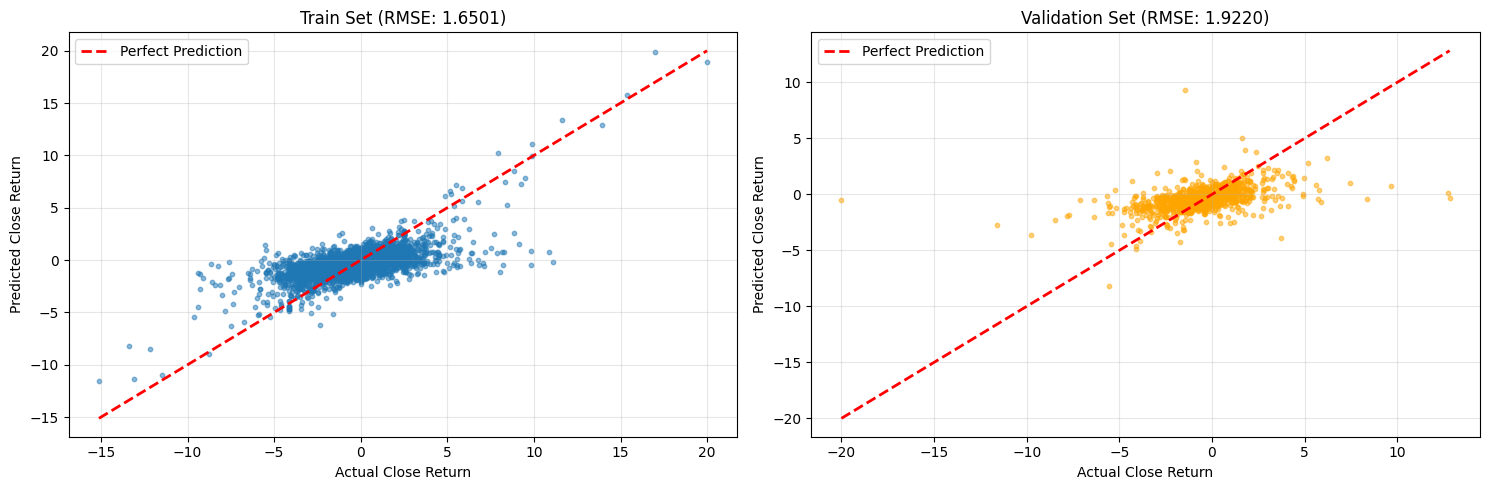

In [20]:
# Plot predictions vs actuals
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training set
axes[0].scatter(train_metrics['targets'], train_metrics['predictions'], alpha=0.5, s=10)
axes[0].plot([train_metrics['targets'].min(), train_metrics['targets'].max()],
              [train_metrics['targets'].min(), train_metrics['targets'].max()],
              'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Close Return')
axes[0].set_ylabel('Predicted Close Return')
axes[0].set_title(f'Train Set (RMSE: {train_metrics["rmse"]:.4f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Validation set
axes[1].scatter(val_metrics['targets'], val_metrics['predictions'], alpha=0.5, s=10, color='orange')
axes[1].plot([val_metrics['targets'].min(), val_metrics['targets'].max()],
             [val_metrics['targets'].min(), val_metrics['targets'].max()],
             'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Close Return')
axes[1].set_ylabel('Predicted Close Return')
axes[1].set_title(f'Validation Set (RMSE: {val_metrics["rmse"]:.4f})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

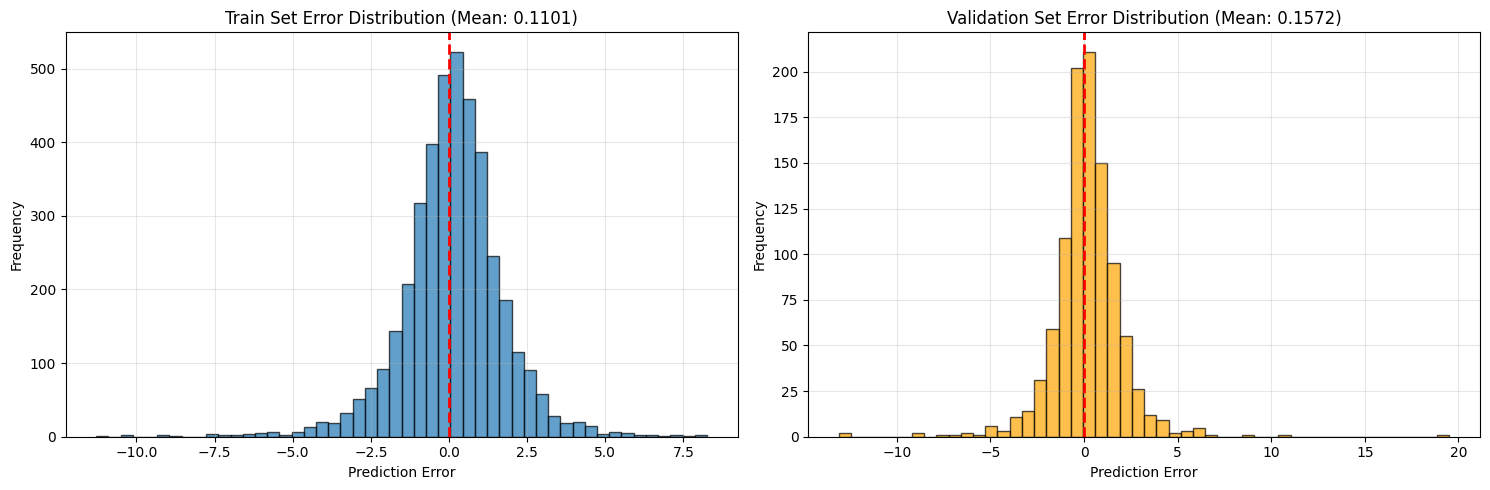

In [21]:
# Plot error distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

train_errors = train_metrics['predictions'] - train_metrics['targets']
val_errors = val_metrics['predictions'] - val_metrics['targets']

axes[0].hist(train_errors, bins=50, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Prediction Error')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Train Set Error Distribution (Mean: {train_errors.mean():.4f})')
axes[0].axvline(0, color='r', linestyle='--', linewidth=2)
axes[0].grid(True, alpha=0.3)

axes[1].hist(val_errors, bins=50, alpha=0.7, edgecolor='black', color='orange')
axes[1].set_xlabel('Prediction Error')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Validation Set Error Distribution (Mean: {val_errors.mean():.4f})')
axes[1].axvline(0, color='r', linestyle='--', linewidth=2)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [22]:
# Analyze feature importance (optional)
def analyze_feature_importance(model, data_loader, device, feature_names):
    """
    Analyze feature importance using permutation importance.
    """
    model.eval()

    # Get a batch of data
    batch_X, batch_y = next(iter(data_loader))
    batch_X = batch_X.to(device)
    batch_y = batch_y.to(device)

    # Get baseline predictions
    with torch.no_grad():
        baseline_preds = model(batch_X)
        baseline_loss = nn.MSELoss()(baseline_preds, batch_y).item()

    # Calculate importance for each feature
    importance_scores = []

    for feature_idx in range(len(feature_names)):
        # Create a copy of the data
        perturbed_X = batch_X.clone()

        # Permute the feature across the sequence dimension
        # This maintains the distribution but breaks the temporal relationship
        perturbed_X[:, :, feature_idx] = perturbed_X[:, :, feature_idx][
            torch.randperm(perturbed_X.size(0))
        ]

        # Get predictions with perturbed feature
        with torch.no_grad():
            perturbed_preds = model(perturbed_X)
            perturbed_loss = nn.MSELoss()(perturbed_preds, batch_y).item()

        # Calculate importance as the increase in loss
        importance = perturbed_loss - baseline_loss
        importance_scores.append(importance)

    # Normalize importance scores
    importance_scores = np.array(importance_scores)
    importance_scores = importance_scores / np.sum(importance_scores)

    # Create a DataFrame for visualization
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance_scores
    }).sort_values('Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

    return importance_df

# Analyze feature importance
print("\nAnalyzing feature importance...")
importance_df = analyze_feature_importance(model, val_loader, config.DEVICE, feature_names)
print(importance_df)


Analyzing feature importance...


IndexError: index 11 is out of bounds for dimension 2 with size 11